In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
__file__ = os.path.abspath('')
dir_path = '/'.join(os.path.realpath(__file__).split('/')[:-1])
sys.path.append(f'{dir_path}/sabatinilab-glm/backend')
sys.path.append(f'{dir_path}/..')
sys.path.append(f'{dir_path}/backend')
sys.path.append(f'{dir_path}/../backend')
# sys.path.append('./backend')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit

import sglm
import sglm_cv
import sglm_pp
import sglm_ez

# Loading in the DesignMatrix (and response) Data

In [3]:
df = pd.read_csv('../C39v2_sampleDesignMat.csv').drop('Unnamed: 0', axis=1).drop('index', axis=1)

# Converting photometry response to a differential rather than raw output

,grnL,grnL_diff
0,921.938,NaN
1,950.588,28.6499
2,944.091,-6.49645
3,948.262,4.17076
4,945.385,-2.87732


Text(0.5, 0, 'Timestep Index')

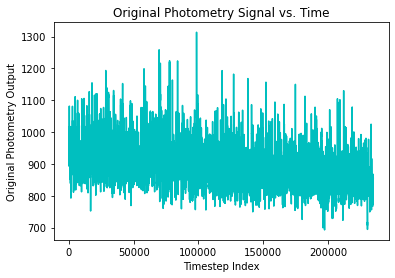

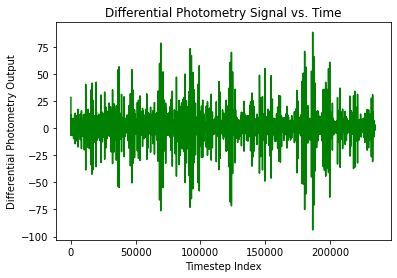

In [4]:
y_setup_col = 'grnL' # photometry response
df = sglm_ez.diff_cols(df, ['grnL'])

# Demonstrative first 5 timesteps of photometry signal vs. differential
display(df[['grnL', 'grnL_diff']].head())

# Plotting original photometry output (excluding first timestep)
plt.figure()
df['grnL'].iloc[1:].plot(color='c')
plt.title('Original Photometry Signal vs. Time')
plt.ylabel('Original Photometry Output')
plt.xlabel('Timestep Index')

# Plotting photometry differential output (excluding first timestep)
plt.figure()
df['grnL_diff'].iloc[1:].plot(color='g')
plt.title('Differential Photometry Signal vs. Time')
plt.ylabel('Differential Photometry Output')
plt.xlabel('Timestep Index')

# Specifying columns to retain for GLM fitting

In [30]:
X_cols = [
    'nTrial', # trial ID
    'iBlock', # block number within session
    'CuePenalty', # lick during cue period (no directionality yet, so binary 0,1) # Keep
    'ENLPenalty', # lick during ENL period (no directionality yet, 0,1) # Keep
    # 'Select', # binary selection lick
    # 'Consumption', # consumption period (from task perspective)
    # 'TO', # timeout trial
    # 'responseTime', # task state cue to selection window
    # 'ENL', # task state ENL window
    'Cue', # task state Cue window # Keep (and all after)
    'decision', # choice lick direction (aligned to select but with directionality -1,1)
    'switch', # switch from previous choice on selection (-1,1)
    'selR', # select reward (-1,1) aligned to selection
    'selHigh', # select higher probability port (-1,1)
    'Reward', # reward vs no reward during consumption period (-1,1)
    'post', # log-odds probability
]

y_col = 'grnL_diff'

In [31]:
# plt.plot(X_setup['post'].iloc[:20000])
# plt.ylim

# Keep only relevant columns specified above

In [32]:
dfrel = df[X_cols + [y_col]].copy()
dfrel = dfrel.replace('False', 0).astype(float)
dfrel = dfrel*1


# Timeshift all non-response columns forward and backward ts timesteps

In [33]:

dfrel = sglm_ez.timeshift_cols(dfrel, X_cols[2:], neg_order=-10, pos_order=10)
X_cols_sftd = sglm_ez.add_timeshifts_to_col_list(X_cols, X_cols[2:], neg_order=-10, pos_order=10)
# X_setup = sglm_ez.diff_cols(X_setup, ['A', 'B'])
# X_setup = sglm_ez.setup_autoregression(X_setup, ['B'], 4)

dfrel = dfrel.dropna()


In [34]:
X_setup = dfrel[X_cols]
# X_setup = dfrel[X_cols_sftd]
y_setup = dfrel[y_col]

X_setup.head()

,nTrial,iBlock,CuePenalty,ENLPenalty,Cue,decision,switch,selR,selHigh,Reward,post
10,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

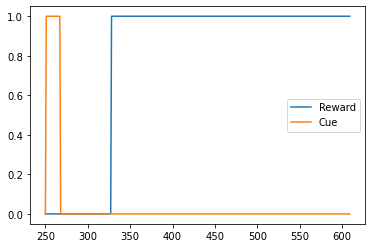

In [35]:
X_setup.iloc[240:600, [9, 4]].plot() # Make this tone one point — make it binned (one and only one point) — use tone duration as binning factor, then make it look like a delta function
# Data has to be collapsed based on when tone starts

In [36]:
# Sum of values in binning windows

In [37]:
X_setup.groupby(['nTrial']).count()

,iBlock,CuePenalty,ENLPenalty,Cue,decision,switch,selR,selHigh,Reward,post
nTrial,,,,,,,,,,
4.0,944,944,944,944,944,944,944,944,944,944
5.0,1151,1151,1151,1151,1151,1151,1151,1151,1151,1151
6.0,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168
7.0,1118,1118,1118,1118,1118,1118,1118,1118,1118,1118
8.0,988,988,988,988,988,988,988,988,988,988
...,...,...,...,...,...,...,...,...,...,...
235.0,1033,1033,1033,1033,1033,1033,1033,1033,1033,1033
236.0,1080,1080,1080,1080,1080,1080,1080,1080,1080,1080
237.0,991,991,991,991,991,991,991,991,991,991


In [38]:
# # investigate_X = X_setup[[_ for _ in X_setup.columns if _ not in ['nTrial', 'iBlock', 'TO', 'Select', 'Consumption', 'selHigh']]]
# # (investigate_X.corr()-np.eye(investigate_X.shape[1])).abs().max(axis=1)

# from sklearn.decomposition import PCA
# pca = PCA()
# X_setup_pca = pca.fit_transform(X_setup[[_ for _ in X_setup.columns if _ != 'TO']].iloc[:, 2:])



In [39]:
# %matplotlib inline
# plt.plot(pca.explained_variance_[1:])
# pca.explained_variance_.min()

In [40]:
pd.DataFrame(X_setup).corr()

,nTrial,iBlock,CuePenalty,ENLPenalty,Cue,decision,switch,selR,selHigh,Reward,post
nTrial,1.000000,0.996441,-4.264678e-06,0.001474,0.000694,5.552620e-04,0.000109,-0.000364,-0.001159,-0.009860,-0.019173
iBlock,0.996441,1.000000,2.559368e-04,0.001944,0.000635,5.063026e-04,0.000506,-0.000760,-0.001692,-0.020557,-0.019497
CuePenalty,-0.000004,0.000256,1.000000e+00,-0.000014,0.015642,-5.542135e-07,0.000053,-0.000033,-0.000043,-0.000900,-0.001529
ENLPenalty,0.001474,0.001944,-1.411918e-05,1.000000,-0.000903,-1.838157e-06,0.000177,-0.000110,-0.000142,-0.002984,-0.005070
Cue,0.000694,0.000635,1.564244e-02,-0.000903,1.000000,-3.543011e-05,0.003402,-0.002126,-0.002729,-0.057512,-0.097731
decision,0.000555,0.000506,-5.542135e-07,-0.000002,-0.000035,1.000000e+00,-0.008470,-0.008480,-0.016958,-0.000117,-0.000199
switch,0.000109,0.000506,5.322220e-05,0.000177,0.003402,-8.470467e-03,1.000000,-0.457423,-0.601490,0.011247,0.019113
selR,-0.000364,-0.000760,-3.325713e-05,-0.000110,-0.002126,-8.480007e-03,-0.457423,1.000000,0.788073,-0.007028,-0.011943
selHigh,-0.001159,-0.001692,-4.268357e-05,-0.000142,-0.002729,-1.695834e-02,-0.601490,0.788073,1.000000,-0.009020,-0.015328
Reward,-0.009860,-0.020557,-8.996227e-04,-0.002984,-0.057512,-1.171207e-04,0.011247,-0.007028,-0.009020,1.000000,0.194331


In [41]:
(pd.DataFrame(X_setup).corr() - np.eye(X_setup.shape[1])).abs().max(axis=1)

nTrial        0.996441
iBlock        0.996441
CuePenalty    0.015642
ENLPenalty    0.005070
Cue           0.097731
decision      0.016958
switch        0.601490
selR          0.788073
selHigh       0.788073
Reward        0.194331
post          0.194331
dtype: float64

In [42]:
# pd.DataFrame(X_setup_pca).corr()

In [43]:
X_setup.describe()

,nTrial,iBlock,CuePenalty,ENLPenalty,Cue,decision,switch,selR,selHigh,Reward,post
count,234908.000000,234908.000000,234908.000000,234908.000000,234908.000000,234908.000000,234908.000000,234908.000000,234908.000000,234908.000000,234908.000000
mean,121.140847,6.577320,0.000004,0.000047,0.017100,0.000009,-0.000817,0.000511,0.000656,0.314166,0.315232
std,68.141723,3.407471,0.002063,0.006843,0.129646,0.031696,0.031686,0.031692,0.031689,0.720528,0.425447
min,4.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,62.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,121.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018520
75%,180.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.881418
max,239.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.988810


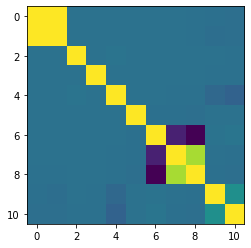

In [44]:
plt.imshow(X_setup.corr())

In [45]:
X_setup

,nTrial,iBlock,CuePenalty,ENLPenalty,Cue,decision,switch,selR,selHigh,Reward,post
10,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
11,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
12,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
13,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
14,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
234913,239.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.958604
234914,239.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.958604
234915,239.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.958604
234916,239.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.958604


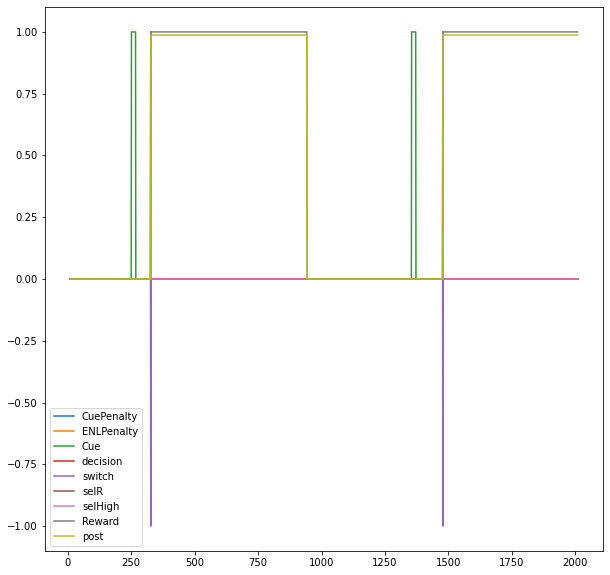

In [53]:
plt.figure(figsize=(10,10))
plt.plot(X_setup.iloc[:2000, 2:])
plt.legend(X_setup.columns[2:])

In [80]:
for col in X_setup.columns:
    print(f'{col}:', X_setup.query(f'{col} > 0').groupby(['nTrial', col])['post'].count().min())

nTrial: 857
iBlock: 6
CuePenalty: 1
ENLPenalty: 1
Cue: 17
decision: 1
switch: 1
selR: 1
selHigh: 1
Reward: 615
post: 615


In [108]:
sglm_ez.timeshift_cols(X_setup, [_ for _ in X_setup.columns[2:] if _ not in ['Cue', 'Reward', 'post']], neg_order=0, pos_order=100)
sglm_ez.timeshift_cols_by_signal_length(X_setup, ['Cue', 'Reward', 'post'], neg_order=0, pos_order=1000, shift_amt_ratio=2).iloc[:50]

,nTrial,iBlock,CuePenalty,ENLPenalty,Cue,decision,switch,selR,selHigh,Reward,...,decision_99,switch_99,selR_99,selHigh_99,CuePenalty_100,ENLPenalty_100,decision_100,switch_100,selR_100,selHigh_100
10,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234913,239.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
234914,239.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
234915,239.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
234916,239.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
X_setup

,nTrial,iBlock,CuePenalty,ENLPenalty,Cue,decision,switch,selR,selHigh,Reward,post
10,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
11,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
12,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
13,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
14,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
234913,239.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.958604
234914,239.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.958604
234915,239.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.958604
234916,239.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.958604


In [115]:
y_setup 

10       -1.94960
11       -0.06610
12       -1.97530
13       -0.36664
14       -1.94936
           ...   
234913    0.07515
234914    0.30675
234915    0.19510
234916    0.44236
234917    0.28564
Name: grnL_diff, Length: 234908, dtype: float64